In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import sys
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [2]:
train_datasets = torchvision.datasets.FashionMNIST(root=".", train=True, 
                                                   transform=transforms.ToTensor(),
                                                   download = True)

In [11]:
test_datasets = torchvision.datasets.FashionMNIST(root=".", train=False, 
                                                 transform=transforms.ToTensor(),
                                                 download=True)

In [5]:
# Check the number of classes 
classes = len(set(train_datasets.targets.numpy()))
print("Number of classes : {}".format(classes))

Number of classes : 10


In [6]:
# Define the model
class CNN(nn.Module):
    
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1 , out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [7]:
# Instantiate the model
model = CNN(classes).cuda()

In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_datasets, 
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, shuffle=False)


In [14]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        t0 = datetime.now()
        
        train_loss = []
        for inputs, targets in train_loader:
            
            # move to GPU
            inputs, targets = inputs.to("cuda:0"), targets.to("cuda:0")
            
            # zero the optimizer gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        test_loss = []
        
        for inputs, targets in test_loader:
            
            # move to GPU
            inputs, targets = inputs.to("cuda:0"), targets.to("cuda:0")
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        test_loss = np.mean(test_loss)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
        print("Epoch : {}/ {} || Train Loss : {:.4f} || Test Loss : {:.4f}".format(epoch, epochs,
                                                                                  train_loss, test_loss))
        
    
    
    return train_losses, test_losses

            
            
            
            

In [11]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=20)

Epoch : 0/ 20 || Train Loss : 0.6642 || Test Loss : 0.5223
Epoch : 1/ 20 || Train Loss : 0.4500 || Test Loss : 0.4234
Epoch : 2/ 20 || Train Loss : 0.3883 || Test Loss : 0.3998
Epoch : 3/ 20 || Train Loss : 0.3534 || Test Loss : 0.3785
Epoch : 4/ 20 || Train Loss : 0.3229 || Test Loss : 0.3669
Epoch : 5/ 20 || Train Loss : 0.3029 || Test Loss : 0.3414
Epoch : 6/ 20 || Train Loss : 0.2842 || Test Loss : 0.3214
Epoch : 7/ 20 || Train Loss : 0.2658 || Test Loss : 0.3306
Epoch : 8/ 20 || Train Loss : 0.2525 || Test Loss : 0.3087
Epoch : 9/ 20 || Train Loss : 0.2367 || Test Loss : 0.3126
Epoch : 10/ 20 || Train Loss : 0.2245 || Test Loss : 0.3172
Epoch : 11/ 20 || Train Loss : 0.2126 || Test Loss : 0.3007
Epoch : 12/ 20 || Train Loss : 0.1994 || Test Loss : 0.3110
Epoch : 13/ 20 || Train Loss : 0.1895 || Test Loss : 0.3377
Epoch : 14/ 20 || Train Loss : 0.1806 || Test Loss : 0.3094
Epoch : 15/ 20 || Train Loss : 0.1719 || Test Loss : 0.3146
Epoch : 16/ 20 || Train Loss : 0.1623 || Test Loss

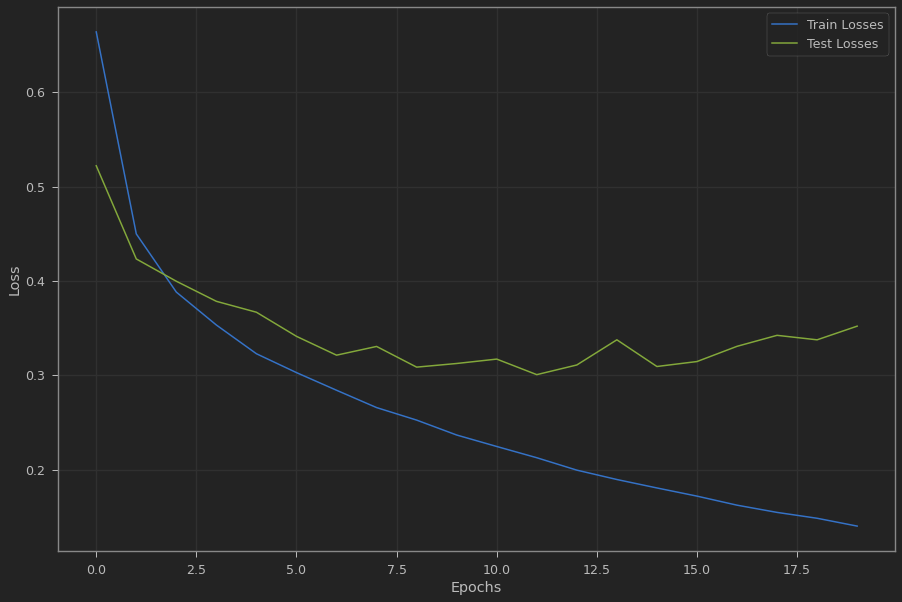

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# Get train and test accuracy

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    
    # move data to GPU
    inputs, targets = inputs.to("cuda:0"), targets.to("cuda:0")
    
    # Forward pass
    outputs = model(inputs)
    
    # Get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0
n_total = 0

for inputs, targets in test_loader:
    
    # move data to GPU
    inputs, targets = inputs.to("cuda:0"), targets.to("cuda:0")
    
    # Forward pass
    outputs = model(inputs)
    
    # Get predictions
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
    
test_acc = n_correct / n_total

print("Train acc : {:.4f} || Test acc : {:.4f}".format(train_acc, test_acc))
    

Train acc : 0.9543 || Test acc : 0.8913


In [20]:
# Confusion matric
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title="Confusion matrix", cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion matrix")
        
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

Confusion matrix, without normalization
[[878   0  23  21   1   1  72   0   4   0]
 [  4 975   0  15   2   0   3   0   1   0]
 [ 25   2 846  12  45   0  68   0   2   0]
 [ 13  12  13 917  14   0  29   0   2   0]
 [  5   2  62  37 777   0 114   0   3   0]
 [  1   0   0   1   0 961   0  26   0  11]
 [145   1  85  24  67   0 669   0   9   0]
 [  0   0   0   0   0  10   0 969   2  19]
 [  6   0   5   2   4   1   7   5 970   0]
 [  1   0   0   0   0   8   0  43   0 948]]


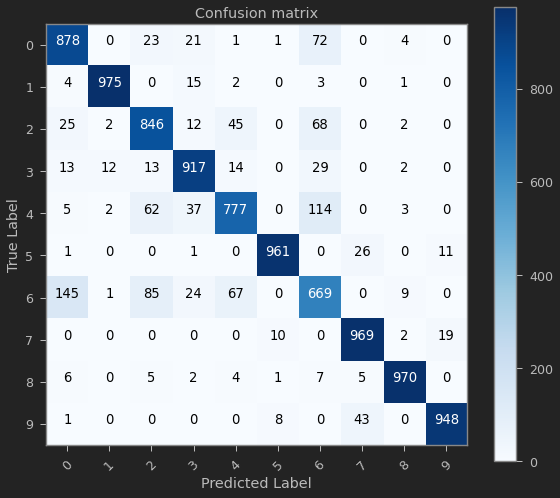

In [23]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
plt.grid(b=False)
for inputs, targets in test_loader:
    inputs, targets = inputs.to("cuda:0"), targets.to("cuda:0")
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [24]:
labels = """T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot""".split("\n")

Text(0.5, 1.0, 'True Label : Pullover | Predicted Label : Dress')

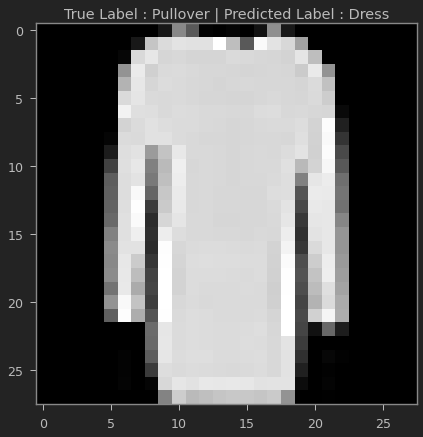

In [28]:
# Show some misclassified examples
plt.grid(b=False)
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
plt.title("True Label : {} | Predicted Label : {}".format(labels[y_test[i]], labels[p_test[i]]))